# Power analysis by simulation

We can think about theh Hypothesis Testing framework as a 2x2 grid - two possible states of reality and two (matching or non-matching) conclusions.

<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/t1t2_error.png" width=80% >

In general, null hypothesis testing concerns one state of reality - that is we **assume the null is true**

In contrast, power analysis concerns the other possible state of reality - we **assume $\mathcal{H_a}$ is true**


In this notebook, focussing on an example of a correlation, we illustrate these hypothetical states of the world by generate two populations of 'data' from alternative realities:

* A **null population** in which $\mathcal{H_o}$ is true, and
* A **correlated population** in which $\mathcal{H_a}$ is true. 

*We will work with correlation (Pearson's $r$), although later we will see that the same approach can be used for difference of means/ the $t$-test.*

We can then:

* work out the proportion of false *positives* we get if $\mathcal{H_o}$ is true (by drawing many samples from the null population)
* work out the proportion of false *negatives* we get if $\mathcal{H_o}$ is true (by drawing many samples from the null population)

The latter gives us the **power** of the analysis.

Although we we later see that power analysis can be run using a built-in function in Python library `statsmodels`, it is useful to understand conceptually the simulation approach, as this gives an idea of what power analysis actually *is*



### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Example

I collect data on end-of year exam scores in Maths and French for 50 high school studehts. Then I calculate the correlation coefficient, Pearson's $r$, between Maths and French scores across my sample of $n=50$ participants.

* $\mathcal{H_0}$ Under the null hypothesis there is no correlation between maths scores and French scores
* $\mathcal{H_a}$ Under the alternative hypothesis, there is a positive correlation

This is a one-tailed test, at the $\alpha=0.05$ level

I observe a correlation of $r=0.25$ (this is my *effect size*)

Can I trust this result? 

### Eyeballing the data

What does a correlation of 0.25 look like for 50 data points?
Here are some examples of datasets that actually have r=0.25:

<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/images/r25_examples.png" width=100% >

**Would you trust those correlations?**

## Simulating the population

* A false positive (type I error) occurs when we get a significant correlation in a sample, even though there is no true correlation in the population

* A false negative (type II error) occurs when we *fail to get* a significant correlation in a sample, even though there is a true correlation in the population

To understand the relationship between these two types of error, we are going to generate two 'populations' of data

* A 'null population' where the true correlation $\rho=0$
* A 'correlated population' where the true correlation $\rho=0.25$

*NOTE -  the symbol rho ($\rho$) denotes the true correlation in the population; it is the population equvalent of $r$ in each sample. If $\rho=0.25$, each sample will have $r \approx 0.25$ but $r$ will be slightly different in each sample.*

Each dataset will have 25000 pairs in it (so 2 columns, 25000 rows), with a correlation between columns of zero (null population) or 0.25 (correlated population). 

By drawing random samples of size $n=50$ from each, we can ask:

* how often do we find a significant correlation when drawing from the null population (false positive, Type I error)?
* how often do we *fail to find* a significant correlation when drawing from the correlated population (false negative, Type II error)?


**You will not be asked to replicate this code so don't worry about the Python details**

## Null population

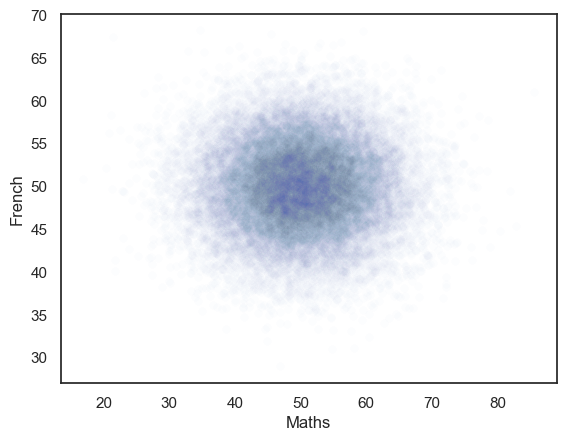

In [2]:
# Code to generate the population with zero correlation - don't worry about understanding this bit

rho=0 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=50
s0=8
s1=5

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rZero=pd.DataFrame(tmp,columns=['Maths','French'])

# plot scatterplot
sns.scatterplot(data=pop_rZero,x='Maths',y='French',alpha=0.01)
plt.show()

The generated dataset has two columns and 25,000 rows. 

The correlation between the two columns should be close to the <tt>r</tt> value we set, ie zero. 

The scatterplot definitely looks like there is no correlation!

In [3]:
# check that the actual correlation is in the 10000 simulated samples
pop_rZero.corr()

,Maths,French
Maths,1.000000,-0.007463
French,-0.007463,1.000000


### Simulating false positives

We can now work out how often we get a significant correlation ($p<0.05$) in samples ($n=50$) drawn from the null population, by drawing 10000 samples and getting the p value for each one using `stats.pearsonr().pvalue`. 

The number of false positives will simply be the proportion of those obtained $p$-values that are below 5%.

In [4]:
nReps=10000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rZero.sample(n=sampleSize) # sample 50 random rows from our null population
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue # correlate and get p-value
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.0423

In [5]:
import scipy
scipy.version.version

'1.11.4'

Hopefully the proportion of samples from the no-correlation distribution with p<0.05 is about.... 0.05. 

## Correlated population

Now we generate a population with a true correlation of $r=0.25$

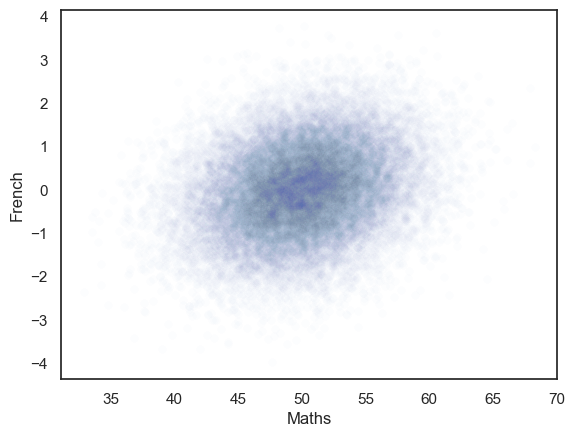

In [6]:
# Code to generate the population with a correlation of rho - don't worry about understanding this bit

rho=0.25 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=0
s0=4.5
s1=1

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rNonZero=pd.DataFrame(tmp,columns=['Maths','French'])

# plot scatterplot
sns.scatterplot(data=pop_rNonZero,x='Maths',y='French',alpha=0.01)
plt.show()


We can check the correlation in the full population of 25000 samples, hopefully this should be close to 0.25.

In [7]:
pop_rNonZero.corr()

,Maths,French
Maths,1.000000,0.243235
French,0.243235,1.000000


### Simulating false negatives

Power is the proportion of the time we fail to find a significant effect, given than an effect is present.

We can investigate power (false negatives) in our correlation example using the same simulation approach we used above for false positives, but using the correlated population.

The question for our *power analysis* is, for samples of size $n=50$, what proportion of the time will I obtain a significant correlation (reject the null)?

To answer that question I am going to draw samples of size $n=50$ from the population *which actually has $\rho$=0.25* and obtain the sample correlation for each of those samples and its $p$-value using `stats.pearsonr().pvalue`. 

I can then ask in what proportion of simulated samples $p<0.05$, ie in what proportion of the simulated samples we manage to reject the null.

In [8]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize) # grab 50 random rows from my correlated population
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue # correlate and get p-value
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.556

So, in my simulation I manage to reject the null in about 40% of simulations (note the exact value you get will vary slightly each time you run the simulation). So my test has a power of 40%

<img src="https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook/main/images/Minion_what.jpg" width=15% >

Yes, that's right. In a population where the *true* correlation between two variables (scores on Maths and French tests) is $\rho=0.25$, for samples of size $n=50$, I will fail to detect a significant correlation (ie, there is a false negative or Type II error) **over half the time**.

This would be true for any data with a true correlation of $\rho=0.25$ and sample size of $n=50$. $n=50$ is really not enough to detect a weakish correlation.

Try changing $n$ in the code block below to be smaller (eg $n$=25) or larger ($n$=150) and see what happens to the power.

**Warning** this takes a few seconds to run on a fastish computer; if you are working on a slow computer or Colab you may wish to skip it

In [9]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.524

## Determining the required sample size

We have just seen that a large sample size is needed to get good power for a weak correlation. How large, exactly?

We can loop over different sample sizes and plot how power increases as sample size increases:

**Warning - if you run this code block it may take a couple of minutes, or longer if your computer is a bit slow. You don't actually need to run it.**


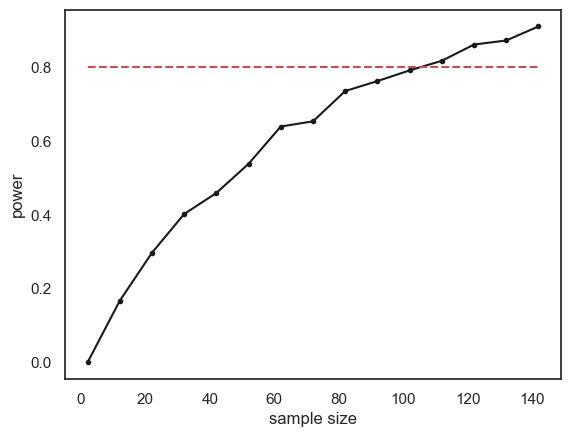

In [10]:
n=range(2,150,10)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=1000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
    power[s]=np.mean(p<0.05)
    
# plot the results
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.show()

The relationship between sample size and power is slightly bumpy as we checked only 1000 simulated samples at each sample size. If you increased nReps to 10,000 the curve would look smoother (but the simulation would take a long time to run).

Conventionally a power of 80% (indicated by the red dashed line on the graph) is considered desirable (80% is a completely arbitrary value by the way). 

What sample size do we need to get power of 80%? It looks from the graph like you would need around n=120. Let's re-run a finer grained simulation in that range:



In [11]:
n=range(120,130,2)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=20000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
    power[s]=np.mean(p<0.05)
    
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.xticks(range(min(n),max(n),5))
plt.show()

KeyboardInterrupt: 

## Recap

* Power is defined as the propotion of the time a significant effect is detected, given that there is an effect (of a certain size in the data)

* Power depends on sample size; a larger sample gives a better chance to detect the effect (if there is one)

* To reach a desirable level of power (say 80%) we need a certain sample size; this sample size depends on the effect size and $\alpha$ value we are working with
    * The smaller the effect size, the larger the sample size neeed to detect it.
    * The more stringent the $\alpha$ value, the larger the sample needed to detect an effect of a given size

* To work out the required sample size, we did the following steps for different values of $n$: 
    * simulated data with the effect size we think is present in the population ($\rho=0.25$)
    * drew many samples of size $n$ and tested for a significant effect
    * worked out the power as the proportion of samples with a significant effect
    
The process of determining the required sample size to detect a certain effect with a certain power is called **power analysis**

## Built in function for power

Now you understand conceptually what power analysis is about, we can move on to running it using a built-on function.

There is a built in function in a package called `statsmodels` for doing power analysis.

In the next notebook we will see this for $t$-tests and correlations.